In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
!pip install kagglehub
import kagglehub
from kagglehub.config import get_kaggle_credentials

Load the dataset

Download the dataset from  Kaggle

In [2]:
path = kagglehub.dataset_download("arsalanjamal002/student-sleep-patterns")
print("PAth to dataset files:", path)

100%|██████████| 11.1k/11.1k [00:00<00:00, 16.6MB/s]

Extracting files...
PAth to dataset files: /root/.cache/kagglehub/datasets/arsalanjamal002/student-sleep-patterns/versions/1


Load the dataset

In [3]:
data = pd.read_csv(f"{path}/student_sleep_patterns.csv")
data.head()

,Student_ID,Age,Gender,University_Year,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01


Data visualization

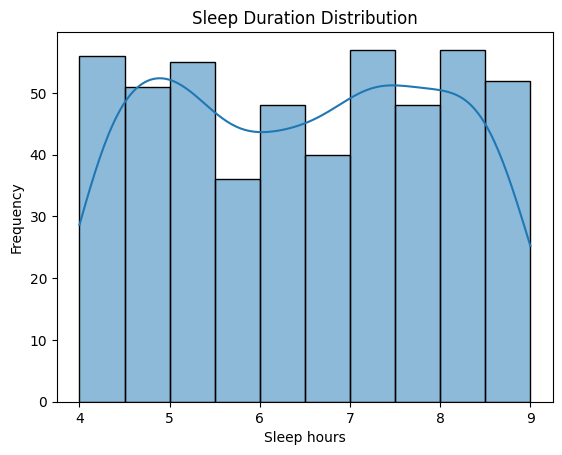

In [4]:
sns.histplot(data['Sleep_Duration'], kde= True)
plt.title('Sleep Duration Distribution')
plt.xlabel('Sleep hours')
plt.ylabel('Frequency')
plt.show()

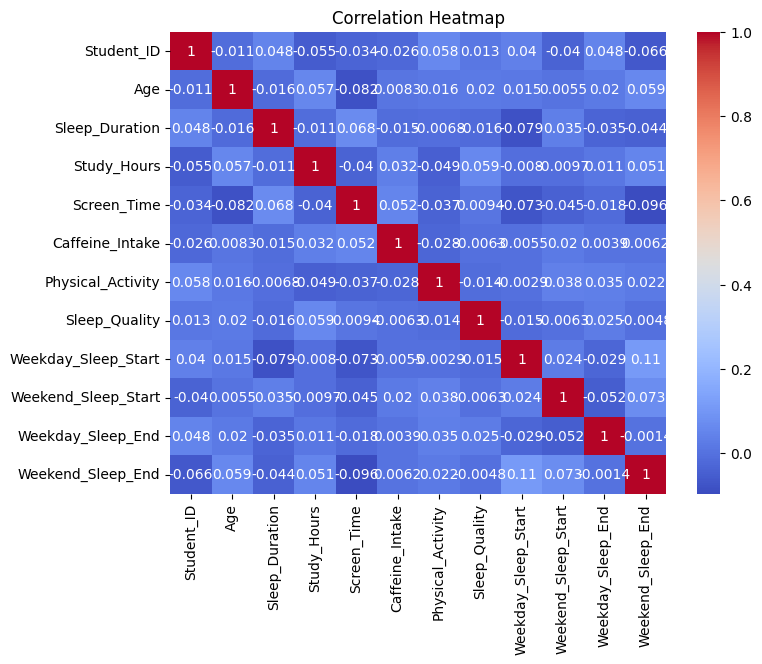

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

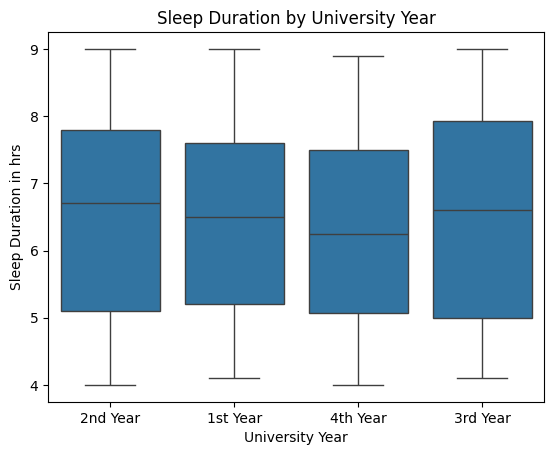

In [6]:
sns.boxplot(x='University_Year', y='Sleep_Duration', data=data)
plt.title('Sleep Duration by University Year')
plt.xlabel('University Year')
plt.ylabel('Sleep Duration in hrs')
plt.show()


Divide the data into training and test sets

In [7]:
categorical_columns = ['Gender', 'University_Year']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
print("Encoded columns:", data_encoded.columns)

Encoded columns: Index(['Student_ID', 'Age', 'Sleep_Duration', 'Study_Hours', 'Screen_Time',
       'Caffeine_Intake', 'Physical_Activity', 'Sleep_Quality',
       'Weekday_Sleep_Start', 'Weekend_Sleep_Start', 'Weekday_Sleep_End',
       'Weekend_Sleep_End', 'Gender_Male', 'Gender_Other',
       'University_Year_2nd Year', 'University_Year_3rd Year',
       'University_Year_4th Year'],
      dtype='object')


Changing continous bin SLeep_duration into catagorical

In [8]:
bins = [0,5,7,10] #Define bin edges
labels = ["Low","Medium","High"] #DEfine category labels
data_encoded['Sleep_Duration'] = pd.cut(data_encoded['Sleep_Duration'], bins=bins, labels=labels)
data_encoded.head()

,Student_ID,Age,Sleep_Duration,Study_Hours,Screen_Time,Caffeine_Intake,Physical_Activity,Sleep_Quality,Weekday_Sleep_Start,Weekend_Sleep_Start,Weekday_Sleep_End,Weekend_Sleep_End,Gender_Male,Gender_Other,University_Year_2nd Year,University_Year_3rd Year,University_Year_4th Year
0,1,24,High,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06,False,True,True,False,False
1,2,21,Medium,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21,True,False,False,False,False
2,3,22,Medium,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92,True,False,False,False,True
3,4,24,Medium,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42,False,True,False,False,True
4,5,20,Low,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01,True,False,False,False,True


In [9]:
x = data_encoded.drop(['Sleep_Duration'], axis =1)#features
y = data_encoded['Sleep_Duration']#target
print(x.dtypes)


Student_ID                    int64
Age                           int64
Study_Hours                 float64
Screen_Time                 float64
Caffeine_Intake               int64
Physical_Activity             int64
Sleep_Quality                 int64
Weekday_Sleep_Start         float64
Weekend_Sleep_Start         float64
Weekday_Sleep_End           float64
Weekend_Sleep_End           float64
Gender_Male                    bool
Gender_Other                   bool
University_Year_2nd Year       bool
University_Year_3rd Year       bool
University_Year_4th Year       bool
dtype: object


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Standardize the data

In [11]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Initialize models

In [12]:
models={
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}


In [13]:
cv_results = {}
for name, model in models.items():
  try:
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring= 'accuracy')
    cv_results[name] = np.mean(scores)
    print(f"{name}: {np.mean(scores)}")
  except Exception as e:
    print(f"Error in {name}: {e}")


Naive Bayes: 0.3771428571428571
Decision Tree: 0.36857142857142855
Random Forest: 0.4228571428571429
SVM: 0.4371428571428571
KNN: 0.39714285714285713


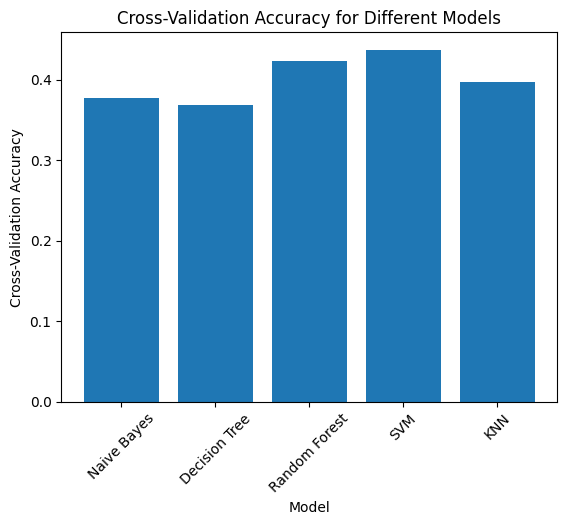

In [14]:
plt.bar(cv_results.keys(), cv_results.values())
plt.title('Cross-Validation Accuracy for Different Models')
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.xticks(rotation=45)
plt.show()

Make Prediction

In [15]:
metrics={
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}
for name, model in models.items():
  try:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report= classification_report(y_test, y_pred, output_dict=True)
    metrics["Model"].append(name)
    metrics["Accuracy"].append(report['accuracy'])
    metrics["Precision"].append(report['weighted avg']['precision'])
    metrics["Recall"].append(report['weighted avg']['recall'])
    metrics["F1 Score"].append(report['weighted avg']['f1-score'])
    print(f"Classification report for {name}:")
    print(classification_report(y_test, y_pred))
  except Exception as e:
    print(f"Error in {name}: {e}")

Classification report for Naive Bayes:
              precision    recall  f1-score   support

        High       0.39      0.52      0.44        58
         Low       0.13      0.05      0.08        37
      Medium       0.40      0.42      0.41        55

    accuracy                           0.37       150
   macro avg       0.31      0.33      0.31       150
weighted avg       0.33      0.37      0.34       150

Classification report for Decision Tree:
              precision    recall  f1-score   support

        High       0.43      0.55      0.48        58
         Low       0.31      0.30      0.30        37
      Medium       0.40      0.29      0.34        55

    accuracy                           0.39       150
   macro avg       0.38      0.38      0.37       150
weighted avg       0.39      0.39      0.39       150

Classification report for Random Forest:
              precision    recall  f1-score   support

        High       0.37      0.50      0.43        58
        

Create Dataframe and save to CSV

In [16]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('metrics.csv', index=False)
print("Evaluation results saved to CSV")


Evaluation results saved to CSV


Plot evaluation metrics as shown in example

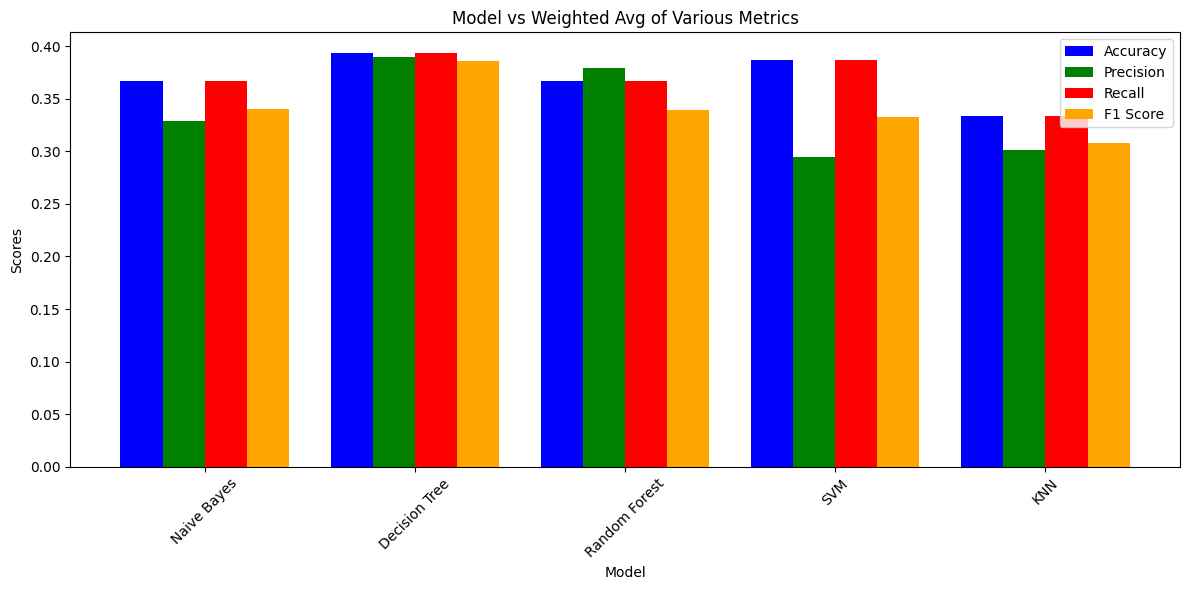

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
width = 0.2#width of bars
x = np.arange(len(metrics['Model']))
ax.bar(x-width*1.5, metrics_df['Accuracy'], width, label='Accuracy', color='blue')
ax.bar(x - width/2, metrics_df['Precision'], width, label='Precision', color='green')
ax.bar(x + width/2, metrics_df['Recall'], width, label='Recall', color='red')
ax.bar(x + width*1.5, metrics_df['F1 Score'], width, label='F1 Score', color='orange')


ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Model'])
ax.set_title('Model vs Weighted Avg of Various Metrics')
ax.set_ylabel('Scores')
ax.set_xlabel('Model')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()